

```
# This is formatted as code
```

# TP3: Fundamental Matrix

## Instructions
Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments).

Upload it the brightspace under Assignment -> Homework 2 section using a single file (ipynb or zip) with the format `NetID_TP3.ipynb`

To execute the notebook, you will need to [install jupyter](http://jupyter.org/install.html). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf.

#### This assignment is an introduction to Two-view (Stereo) Geometry : you will compute the **Fundamental Matrix** F associated with N correspondences from the "house" data. You will estimate the matrix, compute the epipolar lines and implement Hartley's normalization to improve results.

In [192]:
import os
import matplotlib.pyplot as plt
import numpy as np

**0)** Define your path to the folder containing the data points:

In [193]:
path = ''

You can directly use the following functions, especially `read_data` to load points in two chosen views, and `plot_edges` to visualize points from one view and the edges connecting them.

In [194]:
def file_to_array(file_path):
    """
    Params:
    -------
    file_path: str
        path to file with image points.

    Returns:
    --------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    """
    with open(file_path) as f:
        views = dict()
        pt2d = f.readlines()
        for line in pt2d:
            if len(line.split(" ")) == 3:
                pt_id = line.split(" ")[0]
                views[pt_id] = (float(line.split(" ")[1]), float(line.split(" ")[2][:-1]))
    pts = np.zeros((len(views), 2))
    for i in range(len(pts)):
        pts[i] = views[str(i+1)]

    return pts


def read_data(data_path, idx1, idx2):
    """
    Params:
    -------
    data_path: str
        path to folder where 'pt_2D{}' are stored.
    idx1: int
        idx of first view.
    idx2: int
        idx of second view.


    Returns:
    --------
    pts1, pts2, edges_processed
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx2.
    edges_processed: list
        list of tuples. (i, j) is in edges_processed if there is an edge between
        point of idx i and point of idx j.
    """
    pt1_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx1))
    pt2_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx2))

    pts1 = file_to_array(file_path=pt1_2D_path)
    pts2 = file_to_array(file_path=pt2_2D_path)

    # Load edges
    edges_path = os.path.join(path, 'edges')

    with open(edges_path) as f:
        edges_raw = f.readlines()

    edges_processed = []
    for edge in edges_raw:
        if len(edge.split(" ")) == 2:
            edges_processed.append((int(edge.split(" ")[0]), int(edge.split(" ")[1][:-1])))
    min_points = np.minimum(len(pts1), len(pts2))

    return pts1[:min_points], pts2[:min_points], edges_processed


def plot_edges(pts, edges):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    edges: list
        list of tuples. (i, j) is in edges if there is an edge between points of indices i and j.

    Plots edges.
    """

    plt.figure();
    for i, edge in enumerate(edges):
        #print(i)
        coord1 = pts[edges[i][0] - 1]
        coord2 = pts[edges[i][1] - 1]
        x = [coord1[0], coord2[0]]
        y = [coord1[1], coord2[1]]
        plt.plot(x, y, 'ro-');

For this exercise, let us use views 2 and 5 of the house:

**1)** Load the data corresponding to images 2 and 5 using `read_data`. [5]

In [195]:

pts2, pts5, edges_processed = read_data(path,2,5)

**2)** Use `plot_edges` to show show the edges overlayed over images 2 and 5. [5]

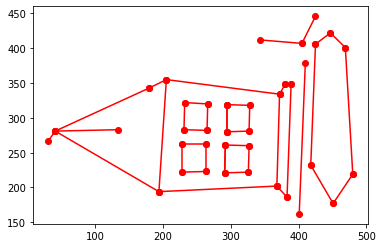

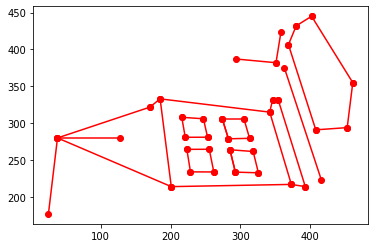

In [196]:

plot_edges(pts2,edges_processed)
plot_edges(pts5,edges_processed)

**3.a)** Compute the fundamental matrix F directly from these points using
homogeneous linear least-squares. [10]

1. Construct the 8x9 matrix \( A \) using the point correspondences.
2. Solve the linear homogeneous equations using Singular Value Decomposition (SVD).
3. Apply the rank constraint to ensure \( F \) has rank 2.
4. Reshape the resulting vector into a \( 3 \times 3 \) matrix

In [197]:
# Compute the fundamental matrix F using homogeneous linear least-squares
def compute_F(pts1, pts2):
   """
   Params:
   -------
   pts1: np.array
         array of size (N, 2). N points of coordinates (x, y) in view 1.
   pts2: np.array
         array of size (N, 2). N points of coordinates (x, y) in view 2.

   Returns:
   --------
   F: np.array
         array of size (3, 3). fundamental matrix.
   """
   u1 = pts1[:, 0]
   v1 = pts1[:, 1]
   u1_p = pts2[:, 0]
   v1_p = pts2[:, 1]
   one = np.ones_like(u1)
   W = np.c_[u1 * u1_p, v1 * u1_p, u1_p, u1 * v1_p, v1 * v1_p, v1_p, u1, v1, one]
   # Use svd to find the lstsq solution for Wf = 0
   u, s, vh = np.linalg.svd(W, full_matrices=True)
   f = vh[-1, :]
   F_t = f.reshape(3, 3)
   # Enforce F_t to F which is rank 2
   u, s, vh = np.linalg.svd(F_t, full_matrices=True)
   s[-1] = 0
   F = u.dot(np.diag(s)).dot(vh)
   return F



# Example usage:
F = compute_F(pts2, pts5)
print(F)
print()
F_p = F / F[2, 2]
print(F_p)


[[ 4.08336118e-07  4.54314846e-06 -3.63858420e-03]
 [-3.40594547e-06  4.93768111e-06 -8.20503446e-04]
 [ 2.46956438e-03 -4.13679234e-03  9.99981438e-01]]

[[ 4.08343698e-07  4.54323279e-06 -3.63865174e-03]
 [-3.40600869e-06  4.93777277e-06 -8.20518677e-04]
 [ 2.46961022e-03 -4.13686913e-03  1.00000000e+00]]


**3.b)** Report the mean distance between the points (for example from view 1) and the corresponding epipolar lines.[10]

In [198]:
def compute_mean_distance(pts1, pts2, E):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    E: np.array
        array of size (3, 3). Essential matrix.

    Returns:
    --------
    mean_distance: float
        mean distance between points (view 1) and epipolar lines (view 2)
    """

    # Get homogeneous coordinates
    pts1_homo = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    pts2_homo = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

    # Compute epipolar lines in view 2
    lines2 = np.dot(E, pts1_homo.T).T  # Lines in homogeneous coordinates

    # Compute distance from each point in view 2 to its corresponding epipolar line
    distances = np.abs(np.sum(pts2_homo * lines2, axis=1)) / np.linalg.norm(lines2[:, :2], axis=1)

    # return Mean distance
    return np.mean(distances)

In [199]:
# Check distances
mean_dist = compute_mean_distance(pts2,pts5,F)
print(mean_dist)

98.82981494661688


**4.a)** Write a function, that given F, draws the epipolar lines associated
with the points from pts1, and overlays them on the points from
pts2, drawn using plot_edges.[10]

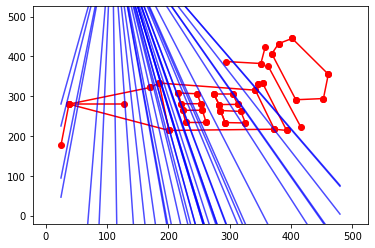

[(25.0, -852.8461381873567, 480.0, 7827.459855132371),
 (25.0, 2560.8550643863205, 480.0, -7384.57190579598),
 (25.0, 1920.465913385002, 480.0, -4530.889194186207),
 (25.0, 46.4248280417508, 480.0, 3820.1558504220566),
 (25.0, 1079.419801516513, 480.0, -783.0450195106345),
 (25.0, 1160.428808419107, 480.0, -1144.0348990567545),
 (25.0, 987.5315440731557, 480.0, -373.57535367377875),
 (25.0, 1635.3190851216834, 480.0, -3260.2265466178474),
 (25.0, 1077.9507335989824, 480.0, -776.4986036135489),
 (25.0, 1164.5103528357538, 480.0, -1162.2229534924722),
 (25.0, 225.11930785502506, 480.0, 3023.862929303857),
 (25.0, 1138.2330526559913, 480.0, -1045.1268454251867),
 (25.0, 887.138794700387, 480.0, 73.79177115662299),
 (25.0, 1449.8838518498076, 480.0, -2433.8956843853152),
 (25.0, 1160.220430571882, 480.0, -1143.1063320140775),
 (25.0, 1108.7954784708254, 480.0, -913.9480201865246),
 (25.0, 1164.7905163322182, 480.0, -1163.4714095680195),
 (25.0, 1107.8215166511156, 480.0, -909.6078810659105

In [200]:
def draw_epipolar_lines(pts1, pts2, F, edges):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    E: np.array
        array of size (3, 3). fundamental matrix.

    Returns:
    --------
    lines: list
        list of tuples. Each tuple contains the coordinates of the two extremal points of the epipolar segment drawn.
    """
    
    lines = []
    
    plot_edges(pts2, edges)
    
    # Compute the plotting range based on points in both images
    all_points = np.vstack([pts1, pts2])
    min_val = np.min(all_points)
    max_val = np.max(all_points)
    range_val = max_val - min_val
    
    plt.xlim([min_val - 0.1 * range_val, max_val + 0.1 * range_val])
    plt.ylim([min_val - 0.1 * range_val, max_val + 0.1 * range_val])

    for pt1 in pts1:
        # Convert to homogeneous coordinates
        pt1_hom = np.append(pt1, 1)  # pt1_hom becomes [x1, y1, 1]
        
        # Compute the coefficients of the line: ax + by + c = 0
        # epipolar_line = [a, b, c]
        epipolar_line = np.dot(F, pt1_hom)  # Computing the epipolar line coefficients using the transpose of F
        
        # Generate x values for plotting the line
        x = np.linspace(min_val, max_val, 10000)
        
        # Calculate y values based on the line equation: ax + by + c = 0 => y = (-a*x - c) / b
        # Check for division by zero in case b is very small
        if np.abs(epipolar_line[1]) > 1e-6:
            y = (-epipolar_line[2] - epipolar_line[0] * x) / epipolar_line[1]
        else:
            y = np.zeros_like(x)  # If b is zero, y cannot be determined from this equation directly
        
        # Plot the line
        plt.plot(x, y, 'b-', alpha=0.7)
        
        # Store the extremal points of the line for output
        lines.append((x[0], y[0], x[-1], y[-1]))

    plt.show()
    return lines    

draw_epipolar_lines(pts2, pts5, F, edges_processed)

**4.b)** Do the same switching the roles of pts1 and pts2.[10]

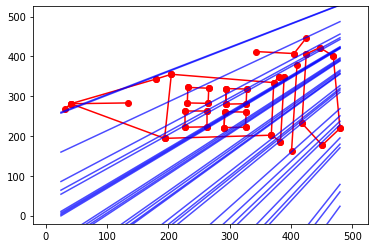

[(25.0, 159.5280099177816, 480.0, 487.1551482389011),
 (25.0, -1470.9980591883386, 480.0, -203.19472756696385),
 (25.0, -74.22856796930951, 480.0, 388.18474379659455),
 (25.0, 53.804807112231465, 480.0, 442.3929078126429),
 (25.0, -56.07443710162821, 480.0, 395.87103733542625),
 (25.0, 10.659423061701242, 480.0, 424.12554546546585),
 (25.0, -219.71327240475145, 480.0, 326.58784599678154),
 (25.0, 3.023551991995111, 480.0, 420.89258725368376),
 (25.0, -245.68486312540097, 480.0, 315.59171121047285),
 (25.0, -147.31444516210368, 480.0, 357.24084955338975),
 (25.0, 257.4302645029128, 480.0, 528.6060704746994),
 (25.0, -530.3313770042072, 480.0, 195.07497171882278),
 (25.0, -1352.6373914328983, 480.0, -153.0818996683808),
 (25.0, -850.3633934134557, 480.0, 59.576332986144145),
 (25.0, -935.5350768342598, 480.0, 23.515418545222104),
 (25.0, -588.6150175388635, 480.0, 170.39820955784018),
 (25.0, 63.964142495538745, 480.0, 446.69427781403226),
 (25.0, -137.44943874899482, 480.0, 361.41760335

In [201]:
draw_epipolar_lines(pts5, pts2, F.T, edges_processed)

**5)** Do the same thing using the Harltley normalization: [50]

**5.a)** Compute the matrices $T_1$ and $T_2$.

In [202]:
def hartley_normalization(points):

    N = points.shape[0]
    centroid = np.mean(points, axis=0)
    dists = np.sqrt(np.sum((points - centroid)**2, axis=1))
    mean_dist = np.mean(dists)
    scale = np.sqrt(2) / mean_dist
    
    T = np.array([
        [scale, 0, -scale*centroid[0]],
        [0, scale, -scale*centroid[1]],
        [0, 0, 1]
    ])

    normalized_points = (T @ np.column_stack((points, np.ones(N))).T).T

    return normalized_points[:, :2], T


pts1_normalized, T1 = hartley_normalization(pts2)
pts2_normalized, T2 = hartley_normalization(pts5)

**5.b)** Compute the new matrice $F'$

In [203]:


F_prime = compute_F(pts1_normalized, pts2_normalized)
# Enforce the constraint that F̃ should have rank 2 by setting the last singular value to 0

U_f, S_f, VT_f = np.linalg.svd(F_prime)
S_f[-1] = 0
F_tilde = U_f @ np.diag(S_f) @ VT_f

# Denormalize the fundamental matrix
# F = T2.T @ F_tilde @ T1



**5.c)** Report the mean distance between the points and the corresponding epipolar lines.

In [204]:
# mean_dist_norm = compute_mean_distance(T_1, T_2, F_prime)
# mean_dist_norm

mean_distance_12 = compute_mean_distance(pts1_normalized, pts2_normalized, F_prime)
print(mean_distance_12)

mean_distance_21 = compute_mean_distance(pts2_normalized, pts1_normalized, F_prime)
print(mean_distance_21)

0.012552580138515982
0.4207974424941474


### We can see that the mean distance has significantly dropped after normalisation 

**5.d)** Draw the epipolar lines associated with the points from `pts2` and overlay them on the points from
`pts1`, drawn using `plot_edges`.

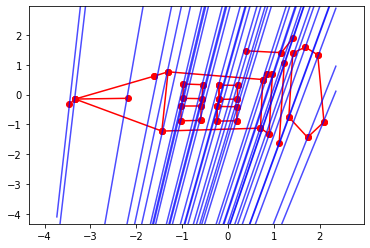

In [205]:
lines = draw_epipolar_lines(pts2_normalized, pts1_normalized, F_prime.T, edges_processed)

**5.e)** Do the same switching the roles of `pts1` and `pts2`. Comment.

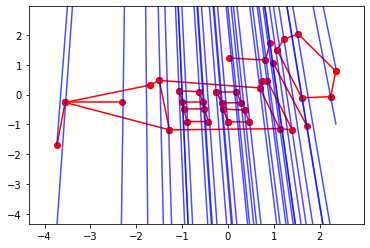

In [206]:
new_lines = draw_epipolar_lines(pts1_normalized,pts2_normalized,F_prime,edges_processed)

##### 1. When we swap `pts1` and `pts2`, we essentially switch the source and destination viewpoints. This swap corresponds to a transformation in the epipolar geometry, affecting how points in one image relate to lines (epipolar lines) in the other.
##### 2. When we swap `pts1` and `pts2`, we compute epipolar lines for the new `pts1` (which were previously `pts2`). These lines now represent the projection of points from the other image (previously `pts1`) onto the current image.
##### 3. Swapping `pts1` and `pts2` changes the perspective from which the scene is viewed in the stereo vision system. This change in perspective can result in different epipolar lines being drawn in the images. Visualizing these lines helps us understand how points in one image correspond to lines in the other, aiding in tasks like stereo matching and depth estimation.

##### The first two graphs without the normalisation show that there is a significant offset due to the difference in the angles at which the cameras are in the real plane. After the normalisation we can see that the points align well and it gives a typical epipolar line outut. 